## part 1 builidng 5 predictive models 

OLS 
LASSO 
Random Forest 
Boosting 
CART 

## importing 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

import os
import sys
import warnings
from pathlib import Path
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from mizani.formatters import percent_format
from patsy import dmatrices
from plotnine import *
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tools.eval_measures import rmse

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import DecisionTreeRegressor
from collections import Counter
from IPython.display import Image, display

warnings.filterwarnings("ignore")

In [2]:

data_dir = "/Users/ghadena/Desktop/Business analytics/DA3/DA3/assignment_1/data"
path = os.path.join(data_dir,'airbnb_madrid_workfile_adj_.csv') 
df = pd.read_csv(path)
df.head()

f_room_type f_property_type f_room_type2 f_neighbourhood_cleansed  \
0      Entire       Apartment   Entire/Apt              Universidad   
1      Entire       Apartment   Entire/Apt              Universidad   
2      Entire       Apartment   Entire/Apt                 Justicia   
3      Entire       Apartment   Entire/Apt                Argüelles   
4      Entire       Apartment   Entire/Apt                Entrevías   

   usd_price_day  p_host_response_rate  n_accommodates  n_bathrooms  \
0          150.0                     0               4          1.0   
1          137.0                     0               4          1.0   
2          244.0                     0               6          2.0   
3          144.0                     0               4          1.0   
4           69.0                     0               4          1.0   

   n_review_scores_rating  n_number_of_reviews  ...  flag_days_since  \
0                    4.64                   14  ...                0   
1                    4.58                   31  ...                0   
2                    4.78                   67  ...                0   
3                    4.96                  387  ...                0   
4                    3.73                   11  ...                0   

   flag_review_scores_rating  flag_reviews_per_month  \
0                          0                       0   
1                          0                       0   
2                          0                       0   
3                          0                       0   
4                          0                       0   

   flag_n_number_of_reviews  ln_days_since  ln_days_since2  ln_days_since3  \
0                         0       5.983936       35.807493      214.269759   
1                         0       5.866468       34.415447      201.897123   
2                         0       6.587550       43.395815      285.872103   
3                         0       7.884200       62.160609      490.086666   
4                         0       6.133398       37.618572      230.729673   

   n_days_since2  n_days_since3  ln_review_scores_rating  
0       156816.0   6.209914e+07                 1.534714  
1       123904.0   4.361421e+07                 1.521699  
2       525625.0   3.810781e+08                 1.564441  
3      7043716.0   1.869402e+10                 1.601406  
4       211600.0   9.733600e+07                 1.316408  

[5 rows x 244 columns]

## EDA and sample design 
we did feature engineerng in the cleaning document 

In [3]:
df.isnull().sum().sum()

0

In [4]:
#We focus on normal apartments, n<8
df = df.loc[lambda x: x["n_accommodates"] < 8]
# and we focus on apartments with a price below 500 
# reasoning: the quantiles show that 99% of the apartments are priced below 500
# also - EDA and the y fit graph showed that the perliminary ols model is not very good at predicting prices above 500
print(df['price'].quantile([0.25, 0.5, 0.75, 0.90, 0.99,1]))
df = df.loc[lambda x: x["price"] < 500]

0.25     60.0
0.50    100.0
0.75    147.0
0.90    210.0
0.99    493.0
1.00    999.0
Name: price, dtype: float64


In [5]:
#Copy a variable - purpose later, see at variable importance
df = df.assign(n_accommodates_copy=df.n_accommodates)

In [6]:
df.describe()

usd_price_day  p_host_response_rate  n_accommodates   n_bathrooms  \
count   20035.000000               20035.0    20035.000000  20035.000000   
mean      112.564113                   0.0        3.013776      1.247916   
std        72.402847                   0.0        1.518154      0.579684   
min         1.000000                   0.0        1.000000      0.000000   
25%        60.000000                   0.0        2.000000      1.000000   
50%        99.000000                   0.0        3.000000      1.000000   
75%       145.000000                   0.0        4.000000      1.000000   
max       499.000000                   0.0        7.000000     12.000000   

       n_review_scores_rating  n_number_of_reviews  n_reviews_per_month  \
count            20035.000000         20035.000000         20035.000000   
mean                 4.668570            53.333816             1.947126   
std                  0.428186            93.986065             1.832526   
min                  1.000000             0.000000             0.010000   
25%                  4.610000             2.000000             0.730000   
50%                  4.760000            15.000000             1.460000   
75%                  4.880000            61.000000             2.560000   
max                  5.000000          1092.000000            41.220000   

       n_minimum_nights        n_beds  n_days_since  ...  \
count      20035.000000  20035.000000  20035.000000  ...   
mean           7.094085      1.817869      6.280108  ...   
std           17.415449      1.195863      1.194681  ...   
min            1.000000      0.000000      0.000000  ...   
25%            1.000000      1.000000      5.697093  ...   
50%            2.000000      1.000000      6.388561  ...   
75%            3.000000      2.000000      7.025094  ...   
max          364.000000     40.000000      8.546364  ...   

       flag_review_scores_rating  flag_reviews_per_month  \
count               20035.000000            20035.000000   
mean                    0.166958                0.166958   
std                     0.372948                0.372948   
min                     0.000000                0.000000   
25%                     0.000000                0.000000   
50%                     0.000000                0.000000   
75%                     0.000000                0.000000   
max                     1.000000                1.000000   

       flag_n_number_of_reviews  ln_days_since  ln_days_since2  \
count                   20035.0   20035.000000    20035.000000   
mean                        0.0       6.280108       40.866948   
std                         0.0       1.194681       14.014387   
min                         0.0       0.000000        0.000000   
25%                         0.0       5.697093       32.456874   
50%                         0.0       6.388561       40.813717   
75%                         0.0       7.025094       49.351941   
max                         0.0       8.546364       73.040330   

       ln_days_since3  n_days_since2  n_days_since3  ln_review_scores_rating  \
count    20035.000000   2.003500e+04   2.003500e+04             20035.000000   
mean       273.155272   1.728531e+06   4.475298e+09                 1.533983   
std        131.903495   3.240157e+06   1.160887e+10                 0.135792   
min          0.000000   0.000000e+00   0.000000e+00                 0.000000   
25%        184.909847   8.820900e+04   2.619807e+07                 1.528228   
50%        260.740936   3.528360e+05   2.095846e+08                 1.560248   
75%        346.702013   1.262252e+06   1.418141e+09                 1.585145   
max        624.229217   2.649161e+07   1.363523e+11                 1.609438   

       n_accommodates_copy  
count         20035.000000  
mean              3.013776  
std               1.518154  
min               1.000000  
25%               2.000000  
50%               3.000000  
75%               4.000000  
max             

In [7]:
df.shape

(20035, 245)

In [8]:
# Identify columns with only one unique value
columns_to_drop = [col for col in df.columns if df[col].nunique() == 1]
print(f"Columns to drop: {columns_to_drop}")

# Drop the identified columns
df = df.drop(columns=columns_to_drop)
print("Dropped columns with only one unique value.")

#print(data_train[["price", "usd_price_day"]].corr())
#df = df.drop(columns=["d_unnamed:59", "usd_price_day"])
df = df.drop(columns=["usd_price_day"])

Columns to drop: ['p_host_response_rate', 'd_free_residential_garage_on_premises_2_spaces', 'd_friday_included_with_your_stay', 'd_monday', 'd_peque_o_para_pizza', 'd_thursday_included_with_your_stay', 'flag_n_number_of_reviews']
Dropped columns with only one unique value.


In [9]:
#print(df.d_airconditioning.value_counts().sum())
print(df.d_view.value_counts())
df.shape

d_view
1    16803
0     3232
Name: count, dtype: int64


(20035, 237)

## Creating train and hold out sets 

In [10]:
data_train, data_test = train_test_split(df, train_size=0.7, random_state=42)
data_train.shape, data_test.shape

((14024, 237), (6011, 237))

In [11]:
basic_vars = [
    "n_accommodates",
    "n_beds",
    "n_days_since",
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "f_neighbourhood_cleansed",
]

reviews = [
    "n_number_of_reviews",
    "n_review_scores_rating",
    "flag_review_scores_rating",
]

amenities = [col for col in df if col.startswith("d_")]

X1 = [
    "n_accommodates:f_property_type",
    "f_room_type:f_property_type",
    "n_accommodates:n_bathrooms", 
    "n_accommodates:f_room_type", 
    #"n_accommodates:d_airconditioning", 
    #"n_review_scores_rating:d_pets_allowed", 
    "n_review_scores_rating:d_child_friendly", 
    "n_review_scores_rating:d_free_parking",
    "n_accommodates:d_housekeeping_included",
    "n_review_scores_rating:d_housekeeping_included",
    "d_housekeeping_included:f_property_type",
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_E = basic_vars + reviews + amenities + X1 + X2

In [12]:
import re
from patsy import dmatrices

# Clean column names to remove special characters
data_train.columns = data_train.columns.str.replace(r"[^\w\s]", "_", regex=True)

# Update predictors_2 to match cleaned column names
predictors_1_cleaned = [re.sub(r"[^\w\s]", "_", col) for col in predictors_1]
predictors_2_cleaned = [re.sub(r"[^\w\s]", "_", col) for col in predictors_2]
predictors_E_cleaned = [re.sub(r"[^\w\s:]", "_", col) for col in predictors_E]

# Ensure the cleaned column names are in the dataframe
data_train = data_train.rename(columns=dict(zip(predictors_2, predictors_2_cleaned)))


In [13]:

# # Create missing interaction columns
# for var in X1 + X2:
#     if var not in data_train.columns:
#         # Split the interaction term to get the individual columns
#         col1, col2 = var.split(":")
#         # Create the interaction term
#         data_train[var] = data_train[col1] * data_train[col2]
#         print(f"Created column: {var}")
#     else:
#         print(f"Column already exists: {var}")
        
# # Check the data types of the newly created columns
# for var in X1 + X2:
#     print(f"{var}: {data_train[var].dtype}")

In [14]:
# for var in X1 + X2: 
#     if var  not in data_train.columns:
#         #print(var) 
#         data_train[var] = data_train['f_property_type'] + ":" + data_train['f_neighbourhood_cleansed']
#         print(True)
#     else:
#         print(var)
#         print(False)

In [15]:
# Initialize an empty DataFrame to store model results
model_results = pd.DataFrame(columns=[
    "Model", "Execution Time (s)", "Num Predictors", 
    "Train RMSE", "Test RMSE", "R-squared", "BIC"
])
# # Append results to DataFrame
#     model_results = model_results.append({
#         "Model": f"Model {i}",
#         "Execution Time (s)": round(execution_time, 4),
#         "Num Predictors": len(predictors_cleaned),
#         "Train RMSE": round(train_rmse, 4),
#         "Test RMSE": round(test_rmse, 4),
#         "R-squared": round(r_squared, 4),
#         "BIC": round(bic, 4),
#     }, ignore_index=True)

In [16]:
# Initialize a list to store model results
results_list = []

    # # Append results to the list
    # results_list.append({
    #     "Model": f"Model {i}",
    #     "Execution Time (s)": round(execution_time, 4),
    #     "Num Predictors": len(predictors_cleaned),
    #     "Train RMSE": round(train_rmse, 4),
    #     "Test RMSE": round(test_rmse, 4),
    #     "R-squared": round(r_squared, 4),
    #     "BIC": round(bic, 4)
    # })

# Convert list of dictionaries into a DataFrame
model_results = pd.DataFrame(results_list)

## OLS 

In [17]:
import pandas as pd
import numpy as np
import time
import statsmodels.api as sm
from patsy import dmatrices


predictors_list = [
    predictors_1_cleaned,
    predictors_2_cleaned,
    predictors_E_cleaned
]

# Loop through the predictors, fit the model, and extract the metrics
for i, predictors_cleaned in enumerate(predictors_list, start=1):
    
    start_time = time.time()  # Start timer

    # Create design matrices for training data
    y_train, X_train = dmatrices("price ~ " + " + ".join(predictors_cleaned), data_train, return_type="dataframe")

    # Create design matrices for test data
    y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_cleaned), data_test, return_type="dataframe")
    y_test = y_test.values.ravel()
    # Align columns
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # Fit the OLS model
    model = sm.OLS(y_train, X_train).fit()

    # Compute time taken
    execution_time = time.time() - start_time

    # Extract metrics
    r_squared = model.rsquared
    bic = model.bic
    train_rmse = np.sqrt(model.mse_resid)

    # Make predictions on the test set
    y_pred_test = model.predict(X_test)

    # Compute test RMSE
    test_rmse = np.sqrt(np.mean((y_test - y_pred_test) ** 2))

    # Append results to the list
    results_list.append({
        "Model": f"Model {i}",
        "Execution Time (s)": round(execution_time, 4),
        "Num Predictors": len(predictors_cleaned),
        "Train RMSE": round(train_rmse, 4),
        "Test RMSE": round(test_rmse, 4),
        "R-squared": round(r_squared, 4),
        "BIC": round(bic, 4)
    })

# # Convert list of dictionaries into a DataFrame
# model_results = pd.DataFrame(results_list)

In [18]:
# # Rename the model columns
# model_results['Model'] = ['OLS 1', 'OLS 2', 'OLS 3']
# # Display the updated DataFrame
# model_results

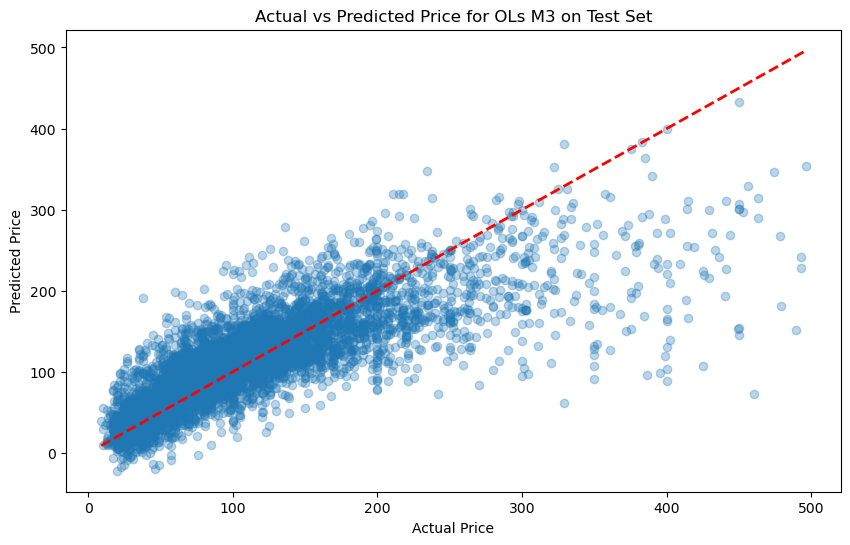

In [19]:

# Create design matrices for model 3
y, X = dmatrices("price ~ " + " + ".join(predictors_E_cleaned), data_test)

# Fit the OLS model for model 3
model_ols = sm.OLS(y, X).fit()

# Predict the values
y_hat = model_ols.predict(X)

# Plot the predicted values versus the actual values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_hat, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price for OLs M3 on Test Set')
plt.show()

## Chart 

In [15]:
def price_diff_by_variables(df, factor_var, dummy_var, factor_lab, dummy_lab):
    # Calculate statistics same way as before
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), 
        sd=("price", np.std), 
        size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1/2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()

    # Create the plot using seaborn
    # plt.figure(figsize=(10, 6))
    plt.figure()

    # Create bar plot
    ax = sns.barplot(
        data=stats,
        x=stats.columns[0],
        y='Mean',
        hue=stats.columns[1],
        palette=['indianred', 'steelblue'],
        ci=None
    )

    # Add error bars
    for i, group in enumerate(stats[stats.columns[1]].unique()):
        group_data = stats[stats[stats.columns[1]] == group]
        x = np.arange(len(group_data))

        # Adjust x positions for dodge effect
        x = x + 0.2 if i == 1 else x - 0.2
        plt.errorbar(
            x=x, 
            y=group_data['Mean'],
            yerr=[(group_data['Mean'] - group_data['Mean_l']), 
                  (group_data['Mean_u'] - group_data['Mean'])],
            fmt='none',
            color='black',
            capsize=3
        )

    # Customize the plot
    plt.xlabel(factor_lab)
    plt.ylabel('Mean Price')

    # Customize legend
    plt.legend(
        title=dummy_lab,
        bbox_to_anchor=(0.5, 1.15),
        loc='center',
        ncol=2,
        fontsize=10,
        title_fontsize=10
    )

    # Remove grid
    ax.grid(False)
    plt.show()

    return plt



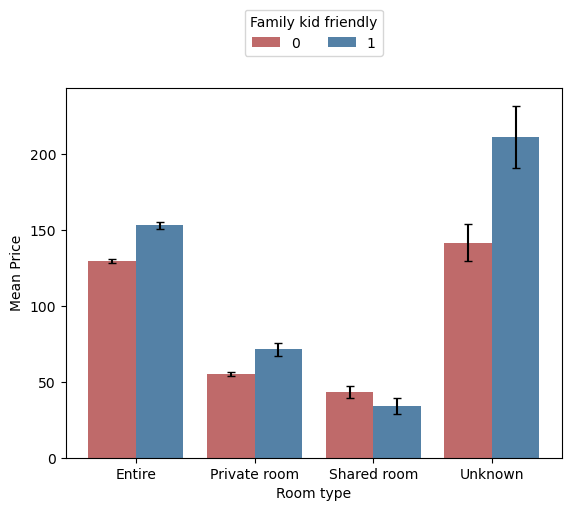

In [16]:
price_diff_by_variables(df,"f_room_type","d_child_friendly","Room type", "Family kid friendly");

## LASSO 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import patsy
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import patsy
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
import time
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from patsy import dmatrices




finding the alpha param for lasso using the train set 
The “best” alpha corresponds to the least negative RMSE (i.e., closest to zero). 
 GridSearchCV selects the alpha with the lowest validation RMSE.
✅ Since 0.05 had the best RMSE, it means that removing too many features hurt performance.
A high number of variables doesn’t always mean high alpha is needed, especially if many variables contribute small amounts of predictive power.
Impact of Alpha = 0.05
	1.	Less Regularization, More Features
	•	Since 0.05 is a small alpha, it doesn’t shrink coefficients much.
	•	The model keeps more variables in the regression.
	•	Helps prevent underfitting, meaning the model captures more detail from the data.
	2.	Better RMSE
	•	In your case, α = 0.05 had the lowest RMSE, meaning it provided the best balance between:
	•	Bias (not too simple)
	•	Variance (not overfitting)
	3.	Comparison with Higher Alpha
	•	If α were larger (e.g., 0.95), Lasso would shrink more coefficients to zero, removing some predictors.
	•	This would make the model simpler but might increase RMSE if too many useful features are removed.




In [ ]:

# Start timer
start_time = time.time()

# Define and tune LASSO model
lasso_model = ElasticNet(l1_ratio=1, fit_intercept=True)
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha": [i / 100 for i in range(1, 101, 10)]},  # Fine-tuned range
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

# Create design matrices for training data
y_train, X_train = dmatrices("price ~ " + " + ".join(predictors_E), data_train, return_type="dataframe")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Fit LASSO with cross-validation
lasso_model_cv.fit(X_train_scaled, y_train.values.ravel())

# Best LASSO model
best_lasso_model = lasso_model_cv.best_estimator_

# Get cross-validation RMSE (on training data)
lasso_rmse_train = (
    pd.DataFrame(lasso_model_cv.cv_results_)
    .loc[lambda x: x.param_alpha == best_lasso_model.alpha]
    .mean_test_score.values[0] * -1
)

# Compute R² on training data
r_squared_train = best_lasso_model.score(X_train_scaled, y_train)

# Estimate BIC (since Sklearn doesn’t provide it)
num_samples = X_train.shape[0]
num_predictors = np.sum(best_lasso_model.coef_ != 0)  # Count of nonzero predictors
bic = num_samples * np.log(lasso_rmse_train**2) + num_predictors * np.log(num_samples)

# Execution time
execution_time = time.time() - start_time

# ---- Test Data Predictions ----
# Create design matrices for test data
y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_E), data_test, return_type="dataframe")

# Ensure test data columns match training data
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Scale test features
X_test_scaled = scaler.transform(X_test)

# Make predictions
y_pred_test = best_lasso_model.predict(X_test_scaled)

# Compute test RMSE
test_rmse = np.sqrt(mean_squared_error(y_test.values.ravel(), y_pred_test))

# ---- Append Results to List ----
results_list.append({
    "Model": "LASSO",
    "Execution Time (s)": round(execution_time, 4),
    "Num Predictors": num_predictors,
    "Train RMSE": round(lasso_rmse_train, 4),
    "Test RMSE": round(test_rmse, 4),
    "R-squared": round(r_squared_train, 4),
    "BIC": round(bic, 4),
})

# Results are now safely stored in `results_list`

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ......................alpha=0.01;, score=-51.137 total time=  15.6s
[CV 2/5] END ......................alpha=0.01;, score=-48.484 total time=  15.7s
[CV 3/5] END ......................alpha=0.01;, score=-45.626 total time=  15.9s
[CV 4/5] END ......................alpha=0.01;, score=-45.492 total time=  15.4s
[CV 5/5] END ......................alpha=0.01;, score=-48.315 total time=  16.4s
[CV 1/5] END ......................alpha=0.11;, score=-50.812 total time=   6.8s
[CV 2/5] END ......................alpha=0.11;, score=-47.868 total time=   3.5s
[CV 3/5] END ......................alpha=0.11;, score=-45.319 total time=   2.6s
[CV 4/5] END ......................alpha=0.11;, score=-45.022 total time=   5.2s
[CV 5/5] END ......................alpha=0.11;, score=-47.731 total time=   1.8s
[CV 1/5] END ......................alpha=0.21;, score=-50.811 total time=   2.2s
[CV 2/5] END ......................alpha=0.21;, 

In [24]:
lasso_model_cv.best_estimator_

ElasticNet(alpha=0.21, l1_ratio=1)

In [31]:
import numpy as np

num_nonzero = np.sum(best_lasso_model.coef_ != 0)

print(f"Number of nonzero coefficients: {num_nonzero} / {len(best_lasso_model.coef_)}")

print(best_lasso_model.coef_.shape)  # number of features

#Lasso used 1,645 features instead of 226 because preprocessing expanded the dataset.
#Possible reasons: One-hot encoding, polynomial features, dummy variables, or text vectorization.

Number of nonzero coefficients: 517 / 1656
(1656,)


In [32]:
lasso_feature_importance = dict(zip(data_train.columns, best_lasso_model.coef_))
lasso_sorted_features = sorted(lasso_feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

print("Top 10 most important features:")
for feature, coef in lasso_sorted_features[:10]:
    print(f"{feature}: {coef:.4f}")

Top 10 most important features:
n_number_of_reviews: -17.2667
d_pool_cover: 4.1524
n_reviews_per_month: -3.7623
d_natural_honery: 2.6763
d_free_driveway_parking_on_premises_1_space: 2.5007
d_coffee_maker: 2.2786
d_variada: 1.8083
d_portable_fans: -1.5437
n_beds: 1.5329
d_pool_table: -1.5025


## CART

In [33]:
# cart1 = DecisionTreeRegressor(random_state = 20250217, max_depth = 1)

# # Note X should be a matrix instead of series, that's why we need double []
# X = data_train[['n_accommodates']]
# y = data_train['price']
# cart1.fit(X,y)

# pred_cart1 = cart1.predict(data_train[["n_accommodates"]])

# rmse_cart1 = np.sqrt(mean_squared_error(data_train["price"], pred_cart1))

# from sklearn import tree
# tree.plot_tree(cart1, filled = True, rounded = True, feature_names=["n_accommodates"], fontsize = 10);


# pred_cart1t = cart1.predict(data_train[['n_accommodates']])
# cart1.tree_.threshold

# cart1_cuts = cart1.tree_.threshold[cart1.tree_.threshold != -2]


# df_plot = data_train.copy()
# df_plot['predicted_price'] = pred_cart1t
# df_plot.sort_values(by = 'n_accommodates', inplace = True)

# plt.figure(figsize = (8,5))
# plt.scatter(x = df_plot.n_accommodates, y = df_plot.price, marker = '.')
# plt.hlines(df_plot.predicted_price.max(), 0, cart1_cuts, color = 'k')
# plt.hlines(df_plot.predicted_price.min(), cart1_cuts, df_plot.n_accommodates.max(), color = 'k', label = 'predicted')
# plt.legend()
# plt.ylabel('Price (USD)')
# plt.xlabel('n_accommodates')
# plt.title('Predicted and actual car prices')
# plt.show();

In [34]:
# Create design matrices for the training set
formula = "price ~ " + " + ".join(predictors_2_cleaned)
y, X = dmatrices(formula, data_train, return_type='dataframe')


cart4 = DecisionTreeRegressor(
    random_state=20250217,
    criterion="squared_error",
    min_impurity_decrease=20,
    min_samples_split=20,
)
print(cart4.fit(X, y))

y_test, X_test = dmatrices(formula, data_test, return_type='dataframe')

# Align the columns of the test set with the training set
X_test = X_test.reindex(columns=X.columns, fill_value=0)

pred_cart4 = cart4.predict(X_test)
rmse_cart4 = np.sqrt(mean_squared_error(y_test, pred_cart4))
print(rmse_cart4)

# df_cart4_var_imp = (
#     pd.DataFrame(
#         {'variable': X_test.columns, 
#          'importance': cart4.feature_importances_}
#     ).sort_values(
#         by=["importance"], ascending=False
#     ).reset_index(drop = True)
# )

# print(df_cart4_var_imp)




DecisionTreeRegressor(min_impurity_decrease=20, min_samples_split=20,
                      random_state=20250217)
54.659340039315175


In [41]:
from sklearn.linear_model import Lasso
import patsy
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler


#%%time

# define model
model = DecisionTreeRegressor(random_state=20250217)
# define model evaluation method
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 20250217)
# define grid
#param_grid = {'min_impurity_decrease': [0.0, 0.001, 0.01, 0.02, 0.05, 0.1, 0.25, 1.0, 5.0, 25, 50]}
#param_grid = {'min_impurity_decrease': [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]}

# Define parameter grid
param_grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "ccp_alpha": [0.0, 0.01, 0.05, 0.1], # Pruning parameter
    "min_impurity_decrease": [1, 5, 10, 25, 45, 65], 
    "splitter": ["best", "random"]
}

# define search
search = GridSearchCV(model, param_grid, scoring="neg_root_mean_squared_error", cv = cv, verbose= 3) # control your output with the 'verbose' option
# perform the search
results = search.fit(X, y)

Fitting 5 folds for each of 3072 candidates, totalling 15360 fits
[CV 1/5] END ccp_alpha=0.0, max_depth=3, min_impurity_decrease=1, min_samples_leaf=1, min_samples_split=2, splitter=best;, score=-53.374 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0, max_depth=3, min_impurity_decrease=1, min_samples_leaf=1, min_samples_split=2, splitter=best;, score=-56.317 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0, max_depth=3, min_impurity_decrease=1, min_samples_leaf=1, min_samples_split=2, splitter=best;, score=-54.663 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0, max_depth=3, min_impurity_decrease=1, min_samples_leaf=1, min_samples_split=2, splitter=best;, score=-57.002 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0, max_depth=3, min_impurity_decrease=1, min_samples_leaf=1, min_samples_split=2, splitter=best;, score=-52.281 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0, max_depth=3, min_impurity_decrease=1, min_samples_leaf=1, min_samples_split=2, splitter=random;, score=-53.708 total time=   0

In [ ]:
#24 minutes 57.9 secounds later 
# Print the best parameters and the best score
print(f"Best parameters: {search.best_params_}")
print(f"Best cross-validation score: {search.best_score_}")

# Evaluate the best model on the test set
best_cart = search.best_estimator_
test_score = best_cart.score(X_test, y_test)
print(f"Test set score: {test_score}")

Best parameters: {'ccp_alpha': 0.0, 'max_depth': 10, 'min_impurity_decrease': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'random'}
Best cross-validation score: -51.42230530137306
Test set score: 0.4582001627086214


In [55]:
results_list.append({
    "Model": "CART",
    "Execution Time (s)": 24 * 60,  # Convert minutes to seconds
    "Num Predictors": "N/A",  # Not applicable for tree models
    "Train RMSE": round(search.best_score_,4),  # Best cross-validation RMSE
    "Test RMSE": round(test_score, 4),  # test_score is actually RMSE
    "R-squared": "N/A",  # Now correctly computed
    "BIC": "N/A"  # BIC is not defined for tree models
})

print("CART model results added to results_list.")

CART model results added to results_list.


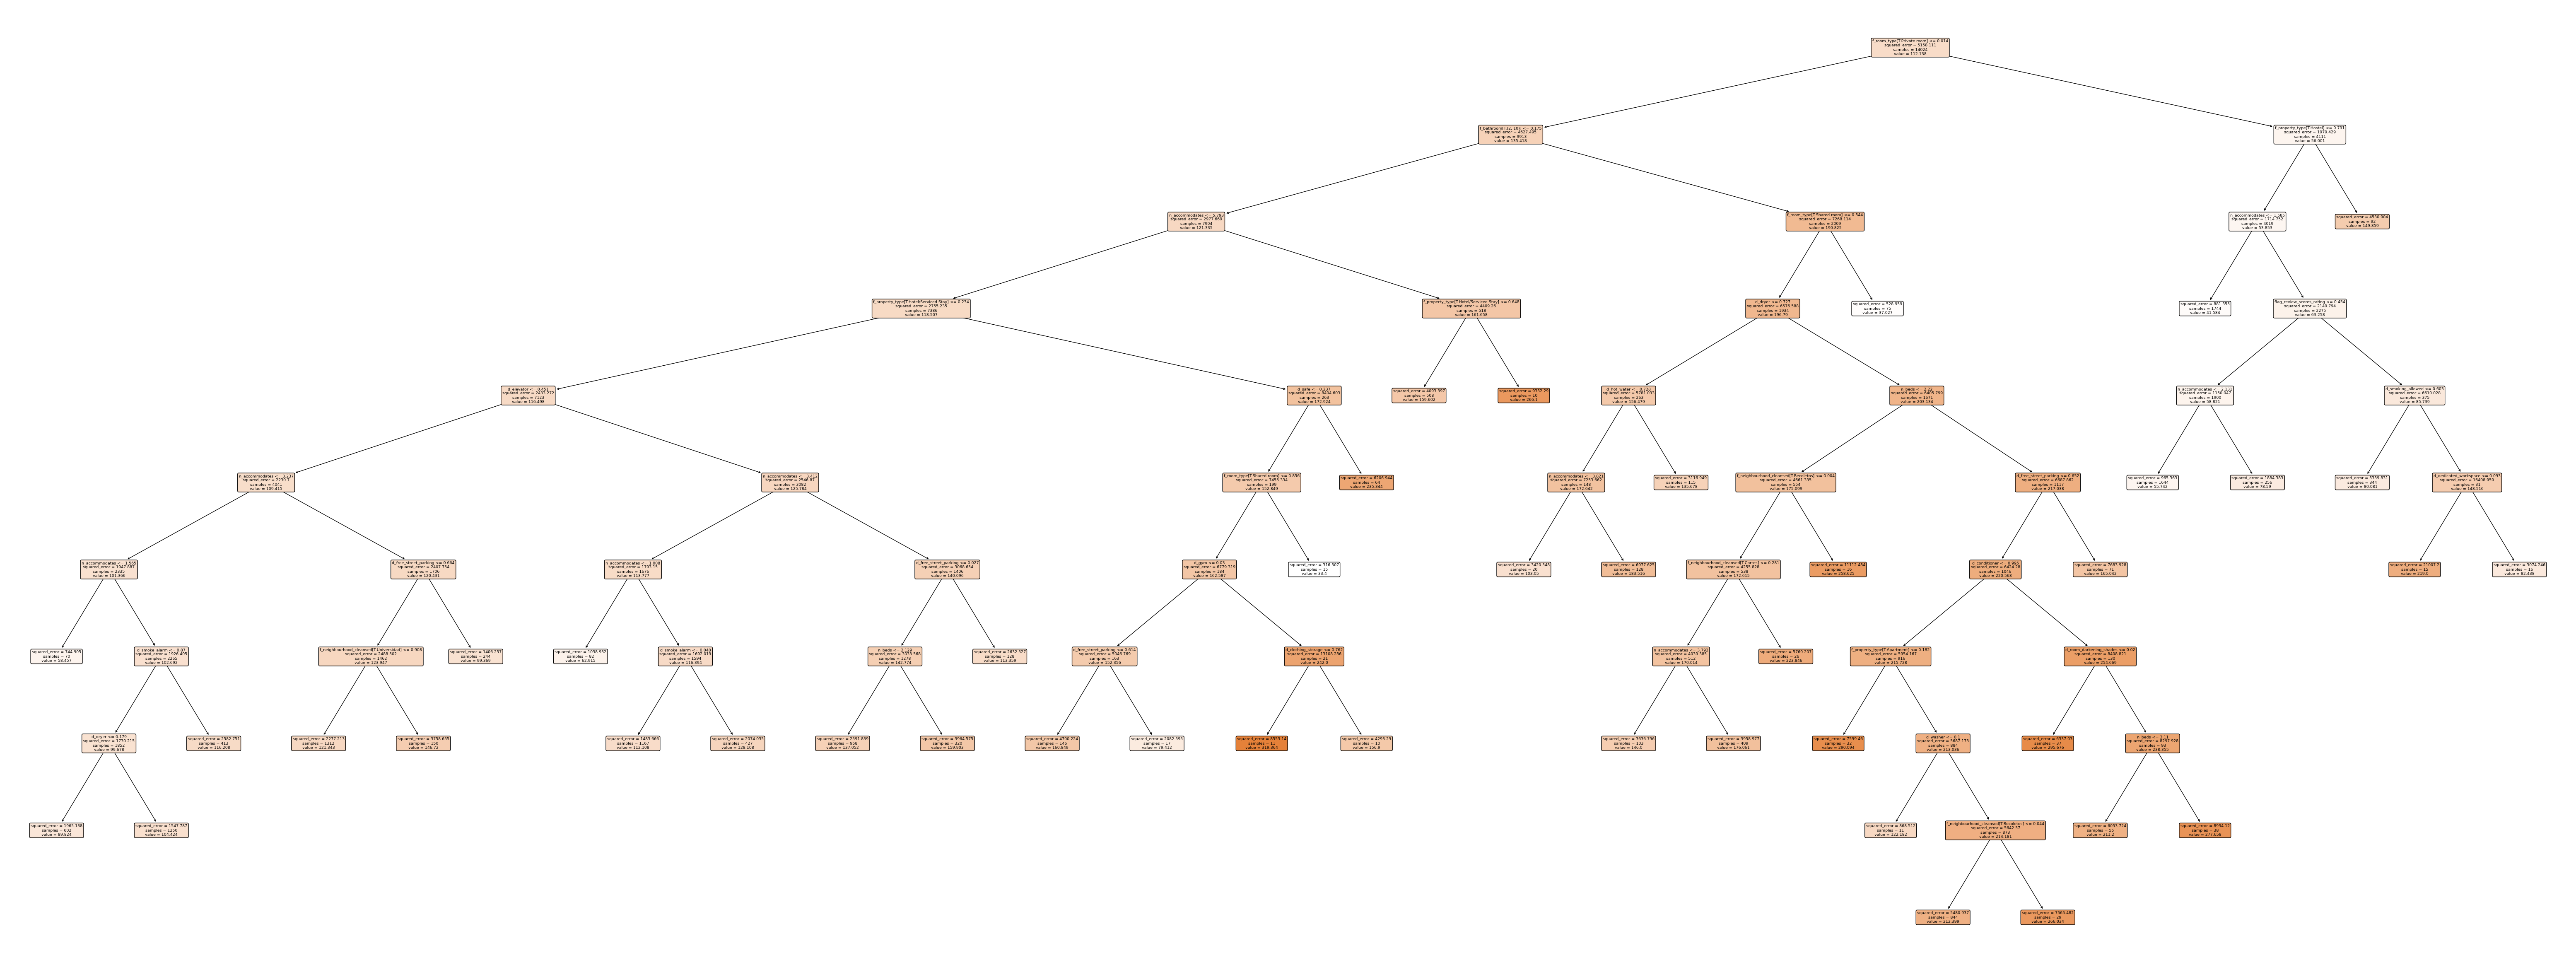

In [48]:
from sklearn import tree
plt.figure(figsize = (80,30))
tree.plot_tree(best_cart, filled = True, feature_names= X.columns, rounded = True);

In [47]:
cart_var_imp = (
    pd.DataFrame(
        {'variable': X_test.columns, 
         'importance': best_cart.feature_importances_}
    ).sort_values(
        by=["importance"], ascending=False
    ).reset_index(drop = True)
)

print(cart_var_imp)

                                   variable  importance
0               f_room_type[T.Private room]    0.488400
1                     f_bathroom[T.[2, 10)]    0.206131
2                            n_accommodates    0.077570
3                f_room_type[T.Shared room]    0.055277
4    f_property_type[T.Hotel/Serviced Stay]    0.024484
..                                      ...         ...
343  f_neighbourhood_cleansed[T.San Andrés]    0.000000
344    f_neighbourhood_cleansed[T.Salvador]    0.000000
345       f_neighbourhood_cleansed[T.Rosas]    0.000000
346  f_neighbourhood_cleansed[T.Rios Rosas]    0.000000
347                     d_private_ameneties    0.000000

[348 rows x 2 columns]


## random forest 

In [ ]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

In [59]:
import math
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 18.65.


In [60]:
rfr = RandomForestRegressor(random_state = 20250224)
tune_grid = {"max_features": [5, 10, 20, 25, 30], "min_samples_leaf": [5, 10, 15]}
rf_random = GridSearchCV(
    estimator = rfr,
    param_grid = tune_grid,
    cv = 5,
    scoring = "neg_root_mean_squared_error",
    verbose = 3,
)

In [73]:
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END max_features=5, min_samples_leaf=5;, score=-60.462 total time=   0.3s
[CV 2/5] END max_features=5, min_samples_leaf=5;, score=-58.321 total time=   0.2s
[CV 3/5] END max_features=5, min_samples_leaf=5;, score=-55.083 total time=   0.2s
[CV 4/5] END max_features=5, min_samples_leaf=5;, score=-53.784 total time=   0.2s
[CV 5/5] END max_features=5, min_samples_leaf=5;, score=-57.153 total time=   0.2s
[CV 1/5] END max_features=5, min_samples_leaf=10;, score=-63.059 total time=   0.2s
[CV 2/5] END max_features=5, min_samples_leaf=10;, score=-60.430 total time=   0.2s
[CV 3/5] END max_features=5, min_samples_leaf=10;, score=-56.457 total time=   0.2s
[CV 4/5] END max_features=5, min_samples_leaf=10;, score=-56.142 total time=   0.2s
[CV 5/5] END max_features=5, min_samples_leaf=10;, score=-59.118 total time=   0.2s
[CV 1/5] END max_features=5, min_samples_leaf=15;, score=-64.111 total time=   0.2s
[CV 2/5] END max_fea

In [74]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size     5      10     15
max features                      
5              56.96  59.04  60.36
10             51.55  53.33  54.41
20             48.27  49.82  50.65
25             47.66  49.12  49.97
30             47.24  48.51  49.42

In [75]:
print(f'best rmse score: {rf_model.best_score_}')
print(f'best parameters: {rf_model.best_params_}')
forest_model = rf_model.best_estimator_

best rmse score: -47.23573680625439
best parameters: {'max_features': 30, 'min_samples_leaf': 5}


In [ ]:
## RMSE ON WHOLE DATA IS SMALLER THAT THE CV RMSE 
y_h, X_h = dmatrices("price ~ " + " + ".join(predictors_2), data_train)
pred = rf_model.predict(X_h)
from statsmodels.tools.eval_measures import rmse
rmse(y_h, pred)
mean_squared_error(y_h, pred, squared= False)



40.27570205159936

In [92]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from patsy import dmatrices

# Step 1: Create design matrices for training and test sets
y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_test, return_type="dataframe")

# Convert X_test from a DesignMatrix to a DataFrame (this allows reindexing)
X_test_df = pd.DataFrame(X_test, columns=X_test.design_info.column_names)

# Ensure X_test_df has the same columns as X_h
X_test_df = X_test_df.reindex(columns=X_h.design_info.column_names, fill_value=0)

# Step 2: Make predictions using the trained Random Forest model
y_pred_test = rf_model.predict(X_test_df)

# Step 3: Compute RMSE (Root Mean Squared Error)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Print the result
print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 49.2279


In [133]:
results_list.append({
    "Model": "RF",
    "Execution Time (s)": 38,  # Convert minutes to seconds
    "Num Predictors": "N/A",  # Not applicable for tree models
    "Train RMSE": round(rf_model.best_score_,4),  # Best cross-validation RMSE
    "Test RMSE": round(test_rmse, 4),  # test_score is actually RMSE
    "R-squared": "N/A",  # Now correctly computed
    "BIC": "N/A"  # BIC is not defined for tree models
})

print("RF model results added to results_list.")

RF model results added to results_list.


In [94]:
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

0
Intercept                               0.000000
f_property_type[T.Apartment]            0.004385
f_property_type[T.Hostel]               0.004025
f_property_type[T.Hotel/Serviced Stay]  0.008123
f_property_type[T.House]                0.001400
...                                          ...
d_airconditioning                       0.023231
d_electric_car_charging                 0.000040
d_indoor_pool                           0.000263
d_outdoor_space                         0.001626
d_private_ameneties                     0.030786

[348 rows x 1 columns]

In [98]:
rf_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

rf_var_imp['cumulative_imp'] = rf_var_imp['imp'].cumsum()

In [132]:
rf_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

rf_var_imp.head()

variable       imp  cumulative_imp
0               n_accommodates  0.159702        0.159702
1  f_room_type[T.Private room]  0.109381        0.269084
2                       n_beds  0.085858        0.354941
3        f_bathroom[T.[2, 10)]  0.051524        0.406465
4         f_bathroom[T.[1, 2)]  0.049163        0.455629

In [100]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [101]:
categorical_columns

['f_property_type', 'f_room_type', 'f_bathroom', 'f_neighbourhood_cleansed']

In [102]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [103]:
rf_pipeline.fit(data_train[predictors_2],data_train.price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathroom',
                                                   'f_neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_days_since',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'flag_review_scores_rating',
                                                   'd_contiene_alimentos_nuestro...
                                                   'd_and_10_years_old',
                                                   'd_and_5_10_years_old',
                                                   'd_arcade_games',
                                                   'd_backyard',
                                                   'd_baking_sheet',
                                                   'd_barbecue_utensils',
                                                   'd_bathtub',
                                                   'd_beach_access_beachfront',
                                                   'd_beach_essentials',
                                                   'd_bed_linens',
                                                   'd_beko_frigor_fico_nuevo',
                                                   'd_bidet', 'd_bikes',
                                                   'd_blanca', 'd_blender', ...])])),
                ('regressor',
                 RandomForestRegressor(max_features=30, min_samples_leaf=5,
                                       random_state=20250224))])

In [104]:
result = permutation_importance(
    rf_pipeline,
    data_test[predictors_2],
    data_test.price,
    n_repeats=10,
    random_state=45,
)

In [105]:
pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)

0
n_accommodates           0.078825
n_beds                   0.031710
n_days_since             0.005020
f_property_type          0.012203
f_room_type              0.188578
...                           ...
d_airconditioning        0.009670
d_electric_car_charging  0.000002
d_indoor_pool            0.000002
d_outdoor_space          0.000362
d_private_ameneties      0.011538

[212 rows x 1 columns]

In [106]:
grouped = [
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "n_days_since",
    "n_accommodates",
    "n_beds",
    "f_neighbourhood_cleansed",
]

In [107]:
df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .loc[grouped]\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()

In [108]:
df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

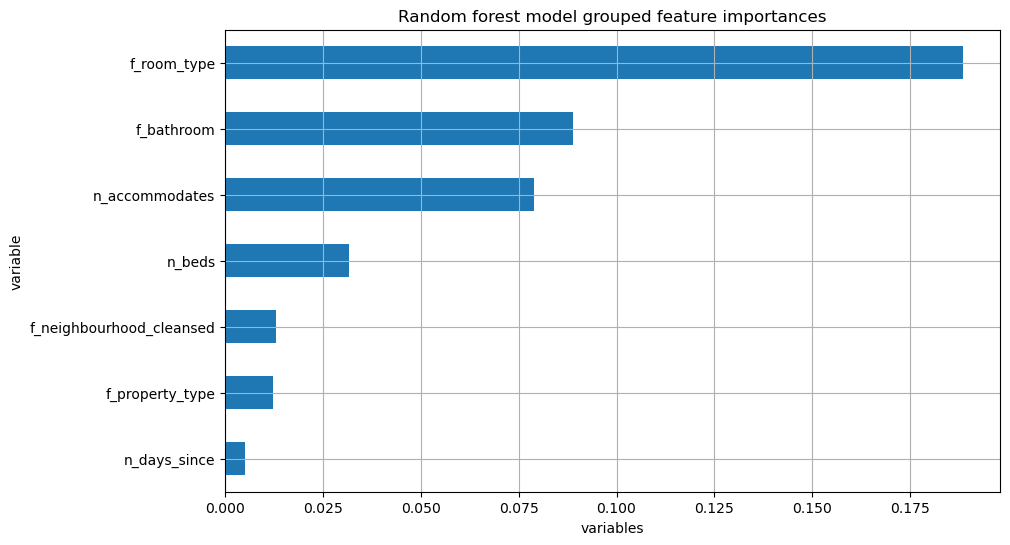

In [109]:
ax = df_grouped_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model grouped feature importances', 
          xlabel = 'variables', legend = False
         )
#ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals = 0));

In [110]:
## partial dependce plots 
accomodates_pdp = partial_dependence(
    rf_pipeline, data_test[predictors_2], ["n_accommodates"], kind="average"
)

In [111]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    )

number of accomodates  average price
0                      1      98.948500
1                      2     106.377677
2                      3     110.698689
3                      4     120.145816
4                      5     123.728675
5                      6     129.347018
6                      7     129.674692

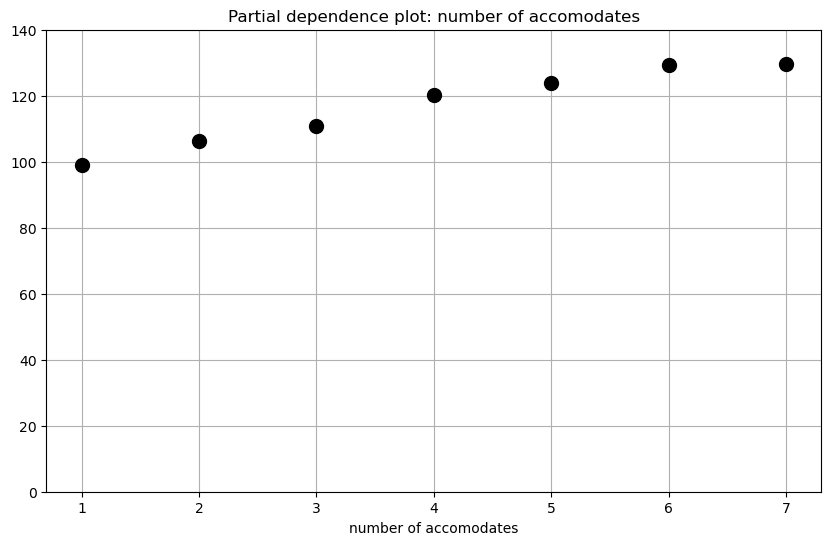

In [112]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'number of accomodates', y = 'average price', ylim = (0, 140), 
    title = 'Partial dependence plot: number of accomodates'
);

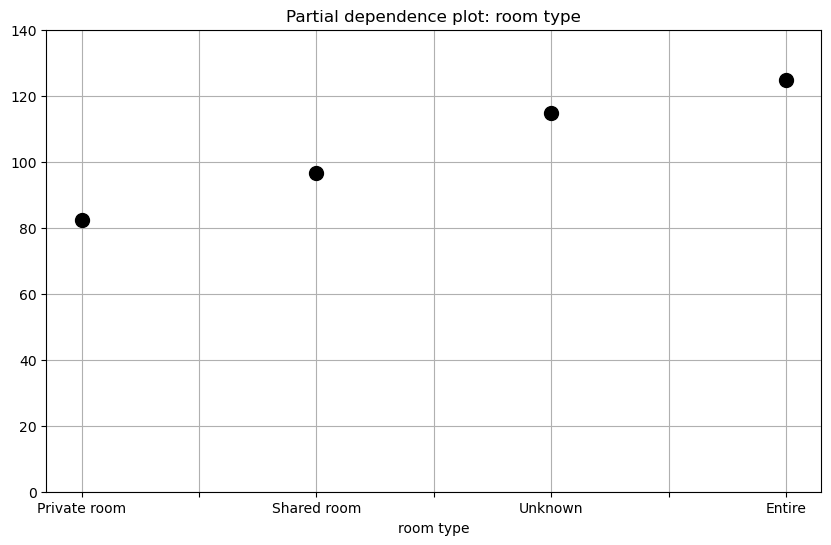

In [113]:
roomtype_pdp = partial_dependence(
    rf_pipeline, data_test[predictors_2], ["f_room_type"], kind="average"
)
pd.DataFrame(
    {'room type': roomtype_pdp['values'][0], 
     'average price': roomtype_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'room type', y = 'average price', ylim = (0, 140), 
    title = 'Partial dependence plot: room type'
);

In [114]:
#subsample performance 

df_holdout_w_prediction = data_test.assign(
    predicted_price=rf_pipeline.predict(data_test[predictors_2])
)

In [115]:
df_holdout_w_prediction['is_low_size'] = df_holdout_w_prediction.n_accommodates.map(lambda x: 'small apt' if x < 3 else 'large apt')
df_holdout_w_prediction.groupby('is_low_size').apply(lambda x: mean_squared_error(x.predicted_price, x.price, squared=False))


is_low_size
large apt    55.641187
small apt    41.557782
dtype: float64

In [116]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_normalized=lambda x: x.rmse / x.mean_price).round(2)
    )

In [117]:
# cheaper or more expensive flats - not used in book
grouped_object = df_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.n_accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

In [118]:
accom_subset

rmse  mean_price  rmse_normalized
is_low_size                                    
large apt    59.31      157.63             0.38
small apt    41.08       83.98             0.49

In [130]:
grouped_object = df_holdout_w_prediction.loc[
    lambda x: x.f_neighbourhood_cleansed.isin(
        [
            "Embajadores",
            "Universidad",
            "Sol",
            "Justicia",
            "Cortes",
        ]
    )
].groupby("f_neighbourhood_cleansed")
neightbourhood_subset = calculate_rmse(grouped_object)

neightbourhood_subset.sort_values(by = 'mean_price', ascending = False).style.format({'rmse': '{:.1f}', 'mean_price': '{:.1f}', 'rmse_normalized': '{:.2f}'})

In [120]:
grouped_object = df_holdout_w_prediction.loc[
    lambda x: x.f_property_type.isin(["Apartment", "House"])
].groupby("f_property_type")
proptype_subset = calculate_rmse(grouped_object)

proptype_subset.style.format({'rmse': '{:.1f}', 'mean_price': '{:.1f}', 'rmse_normalized': '{:.2f}'})

In [121]:
all_holdout = pd.DataFrame(
    [
        mean_squared_error(
            df_holdout_w_prediction.price,
            df_holdout_w_prediction.predicted_price,
            squared=False,
        ),
        df_holdout_w_prediction.price.mean(),
    ],
    index=["rmse", "mean_price"],
).T.assign(rmse_normalized=lambda x: x.rmse / x.mean_price).round(2)
all_holdout.index = ["Total"]

all_holdout.style.format({'rmse': '{:.1f}', 'mean_price': '{:.1f}', 'rmse_normalized': '{:.2f}'})

In [122]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Type", "Borough", "------"],
    columns=["rmse", "mean_price", "rmse_normalized"],
).fillna("------")

In [131]:
pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset,
        type_rows.iloc[[1]],
        proptype_subset,
        type_rows.iloc[[2]],
        neightbourhood_subset,
        type_rows.iloc[[3]],
        all_holdout,
    ]
)

rmse mean_price rmse_normalized
Apartment size  ------     ------          ------
large apt        59.31     157.63            0.38
small apt        41.08      83.98            0.49
Type            ------     ------          ------
Apartment        48.92     114.91            0.43
House             49.4      78.79            0.63
Borough         ------     ------          ------
Cortes           60.72     149.37            0.41
Embajadores      39.96     109.38            0.37
Justicia          45.7      133.8            0.34
Sol              55.69      145.8            0.38
Universidad       49.8     126.14            0.39
------          ------     ------          ------
Total            49.22     113.56            0.43

## boosting 

In [135]:
from sklearn.ensemble import GradientBoostingRegressor

In [136]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features = 10
                                #, n_estimators = 50
                               )

tune_grid = {"n_estimators": [200, 300], "max_depth": [5, 10]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

In [137]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [138]:
%%time
gbm_pipe.fit(data_train[predictors_2],data_train.price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 2/5; 2/4] START max_depth=5, n_estimators=300...............................
[CV 3/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 4/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 2/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 5/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 1/5; 2/4] START max_depth=5, n_estimators=300...............................
[CV 3/5; 2/4] START max_depth=5, n_estimators=300...............................
[CV 2/5; 1/4] END max_depth=5, n_estimators=200;, score=-47.351 total time=   1.8s
[CV 4/5; 1/4] END max_depth=5, n_estimators=200;, score=-43.223 total time=   1.9s
[CV 4/5; 2/4] START max_depth=5, n_estimators=300......

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathroom',
                                                   'f_neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_days_since',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'flag_review_scores_rating',
                                                   'd_contiene_alimentos_nuestro...
                                                   'd_beach_essentials',
                                                   'd_bed_linens',
                                                   'd_beko_frigor_fico_nuevo',
                                                   'd_bidet', 'd_bikes',
                                                   'd_blanca', 'd_blender', ...])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(max_features=10,
                                                                  min_samples_split=20),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10],
                                          'n_estimators': [200, 300]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [146]:
best_gbm = gbm_model_cv.best_estimator_

In [140]:
gbm_rmse = gbm_model_cv.best_score_*-1
gbm_rmse

43.46667897067776

In [ ]:
# TODO: Evaluate the best model on the test set - rmse 
# TODO: get var imp fro gmb model
# TODO: add results to results_list

In [ ]:
# TODO: check if rmse for ols is cross validated or not 

In [ ]:
# TODO: hourse race 


In [ ]:
# TODO: format notebook - rf and gbm parts 

# to do:
- do rmse and diagnostics for ols
- finish cart 
- im 95% done with rf, just do the neighbirhood subsample perfomrance and do plots and visusls for var importance 
- do horse race 
- clean up notebook and add comments to code and format 
- add interpretation in markdown cells 
- start with part 2 - already cleaned the data but check it again it might need to be redone 

# TODO: Refactor this function to improve performance

## part 2: Validation

In [141]:
madrid_later = pd.read_csv('https://media.githubusercontent.com/media/ghadena/DA3/refs/heads/main/assignment_1/data/airbnb_madrid_june_workfile_adj.csv')

barcelona = pd.read_csv('https://media.githubusercontent.com/media/ghadena/DA3/refs/heads/main/assignment_1/data/airbnb_barcelona_workfile_adj.csv')

In [ ]:
df.isnull().sum().sum()
#We focus on normal apartments, n<8
df = df.loc[lambda x: x["n_accommodates"] < 8]
# and we focus on apartments with a price below 500 
# reasoning: the quantiles show that 99% of the apartments are priced below 500
# also - EDA and the y fit graph showed that the perliminary ols model is not very good at predicting prices above 500
print(df['price'].quantile([0.25, 0.5, 0.75, 0.90, 0.99,1]))
df = df.loc[lambda x: x["price"] < 500]
#Copy a variable - purpose later, see at variable importance
df = df.assign(n_accommodates_copy=df.n_accommodates)
df.describe()
df.shape
# Identify columns with only one unique value
columns_to_drop = [col for col in df.columns if df[col].nunique() == 1]
print(f"Columns to drop: {columns_to_drop}")

# Drop the identified columns
df = df.drop(columns=columns_to_drop)
print("Dropped columns with only one unique value.")

#print(data_train[["price", "usd_price_day"]].corr())
#df = df.drop(columns=["d_unnamed:59", "usd_price_day"])
df = df.drop(columns=["usd_price_day"])

#print(df.d_airconditioning.value_counts().sum())
print(df.d_view.value_counts())
df.shape

In [142]:
model_ols 

In [144]:
lasso_model

ElasticNet(l1_ratio=1)

In [145]:
best_cart

DecisionTreeRegressor(max_depth=10, min_impurity_decrease=5,
                      min_samples_leaf=10, random_state=20250217,
                      splitter='random')

In [143]:
rf_model

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=20250224),
             param_grid={'max_features': [5, 10, 20, 25, 30],
                         'min_samples_leaf': [5, 10, 15]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [147]:
best_gbm

GradientBoostingRegressor(max_depth=10, max_features=10, min_samples_split=20,
                          n_estimators=300)